# 1. 호텔 예약 취소율 데이터 분석

1. 무슨 속성을 비교할 것인가?
- is_canceled에서 전체 예약 취소율 비교  
※이때 reservation_status가 No-Show를 포함한 버전과 포함하지 않은 버전 분리 필요
- Resort Hotel과 City Hotel별 예약 최소율 비교: 호텔별 데이터프레임 분리 필요
- 아기, 어린이 어른을 하나로 조합해 인원수별 취소율 비교: 컬럼 추가 및 필터링 필요
- is_repeated_guest를 통해 반복 이용 고객수를 측정

2. 어떤 것을 제외할 것인가?
- stays_in_weekend_nights와 stays_in_week_nights는 숙박인지 예약인지 구별할 수 없으므로 주중/주말 숙박률 비교 어려움
- 국가별 취소율에서 예약 자체의 취소율을 구성하는 조건을 찾기 어렵다 판단하여 country는 제외
- 일별, 월별 예약 취소율 또한 호텔 내부적인 요소를 찾기 어려우므로 제외

3. 무엇을 알아낼 것인가?
- 리조트 호텔과 도시 호텔 중 어느쪽이 예약율 및 취소율이 높은가?
- 가족(혹은 다수)에 친화적인가 비즈니스 목적(혹은 소수)에 친화적인가?
- 고객이 서비스에 만족하는가?



# 2. 데이터 기본 정보 확인

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

## 2.1. 한글 폰트 가져오기

In [ ]:
# 리눅스 시스템에서 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
# 구글 드라이브 마운트
drive.mount('/content/drive')

# 드라이브 안에 있는 데이터 파일 경로
file_path = "/content/drive/MyDrive/codeit/스프린트미션/data/hotel_data_modified.csv"

# 폰트 설정
plt.rc('font', family='NanumBarunGothic')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2.2. 데이터셋 불러오기

In [ ]:
# 데이터셋 불러오기
hotel_booking = pd.read_csv(file_path)

hotel_booking

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,C,C,3,NaN,NaN,0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,C,C,4,NaN,NaN,0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,A,C,0,NaN,NaN,0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,A,A,0,304.0,NaN,0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,A,A,0,240.0,NaN,0,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,A,A,0,394.0,NaN,0,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,E,E,0,9.0,NaN,0,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,D,D,0,9.0,NaN,0,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,A,A,0,89.0,NaN,0,0,0,Check-Out,2017-09-07


## 2.3. 데이터 정보 출력 및 전처리

1. `reservation_status` 열의 No-Show 정보 확인

In [ ]:
print("데이터 크기:", hotel_booking.shape)

print("\n데이터 타입 및 결측치 정보")

print(hotel_booking.info())



print("\n기초 통계량")

print(hotel_booking.describe(include='all'))   # 숫자형 + 범주형 모두 포함

데이터 크기: (119390, 29)

데이터 타입 및 결측치 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 n

In [ ]:
"""
reservation_status에서 no_show 정보 확인
no_show 레코드에서는, 비록 is_canceled가 1(취소값)로 되어 있으나 고객이 자의적으로 예약을 취소한 것이 아니므로 분리 필요
"""
no_show_condition = hotel_booking['reservation_status'] == 'No-Show'

hotel_booking[no_show_condition]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
122,Resort Hotel,1,36,2015,July,27,4,0,1,1,...,E,G,1,250.0,NaN,0,0,0,No-Show,2015-07-04
328,Resort Hotel,1,55,2015,July,29,12,4,10,2,...,D,D,2,8.0,NaN,0,0,1,No-Show,2015-07-12
343,Resort Hotel,1,47,2015,July,29,12,2,3,2,...,F,F,0,241.0,NaN,0,0,0,No-Show,2015-07-12
467,Resort Hotel,1,6,2015,July,29,17,0,2,2,...,A,C,0,241.0,NaN,0,0,1,No-Show,2015-07-17
472,Resort Hotel,1,3,2015,July,29,17,0,2,1,...,A,A,0,5.0,NaN,0,0,0,No-Show,2015-07-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104650,City Hotel,1,1,2017,February,5,1,0,0,1,...,A,A,0,NaN,153.0,0,0,1,No-Show,2017-02-01
108459,City Hotel,1,31,2017,July,29,16,2,0,1,...,A,A,1,NaN,NaN,0,0,2,No-Show,2017-07-16
108829,City Hotel,1,25,2017,May,18,6,2,1,1,...,E,F,0,NaN,450.0,0,0,0,No-Show,2017-05-06
111925,City Hotel,1,6,2017,July,29,17,1,0,1,...,A,D,0,NaN,238.0,0,0,0,No-Show,2017-07-17


### 2.3.1. 결측값 확인

In [ ]:
print("\n 결측치 개수")

print(hotel_booking.isna().sum())


 결측치 개수
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
agent                              16340
company                           112593
days_in

### 2.3.2. 결측값 처리 - 제거
- agent와 company는 결측값이 너무 많고 속성의 특징상 예약 취소율과의 연관성이 낮다고 생각되어 제거한다.  
- children은 0으로 대체한다.

In [ ]:
hotel_booking = hotel_booking.drop(['agent', 'company'], axis=1)

In [ ]:
# children 열의 결측치 0으로 대체
hotel_booking['children'] = hotel_booking['children'].fillna(0)

In [ ]:
hotel_booking['children'] = hotel_booking['children'].astype('int64')

### 2.3.3. 중복값 확인

인덱스를 제외한 속성값이 완전히 같더라도 완전히 동일한 인물의 레코드라고 생각하기에는 고유키(primary key)라고 할 수 있는 열이 없으므로 별도로 처리하지 않는다.

In [ ]:
hotel_booking[hotel_booking.duplicated()]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,0,A,A,0,0,0,1,Check-Out,2015-07-03
22,Resort Hotel,0,72,2015,July,27,1,2,4,2,...,0,0,A,A,1,0,0,1,Check-Out,2015-07-07
43,Resort Hotel,0,70,2015,July,27,2,2,3,2,...,0,0,E,E,0,0,0,1,Check-Out,2015-07-07
138,Resort Hotel,1,5,2015,July,28,5,1,0,2,...,0,0,D,D,0,0,0,0,Canceled,2015-07-01
200,Resort Hotel,0,0,2015,July,28,7,0,1,1,...,0,0,A,A,0,0,0,3,Check-Out,2015-07-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119349,City Hotel,0,186,2017,August,35,31,0,3,2,...,0,0,D,D,0,0,0,2,Check-Out,2017-09-03
119352,City Hotel,0,63,2017,August,35,31,0,3,3,...,0,0,D,D,0,0,0,2,Check-Out,2017-09-03
119353,City Hotel,0,63,2017,August,35,31,0,3,3,...,0,0,D,D,0,0,0,2,Check-Out,2017-09-03
119354,City Hotel,0,63,2017,August,35,31,0,3,3,...,0,0,D,D,0,0,0,2,Check-Out,2017-09-03


# 3. 수치형 데이터 상관관계 확인
- 수치형 데이터의 열만 모은 리스트 생성
- 히트맵을 통해 전체 상관관계를 확인하고 추가로 조사할 사항이 있을지 확인

In [ ]:
# 수치형 데이터 열 리스트 추출

numeric_cols = hotel_booking.select_dtypes(include=[np.number]).columns # np.number은 모든 수치형 데이터 타입을 포괄하는 키워드
numeric_cols

Index(['is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')

## 3.1. 상관관계 히트맵

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


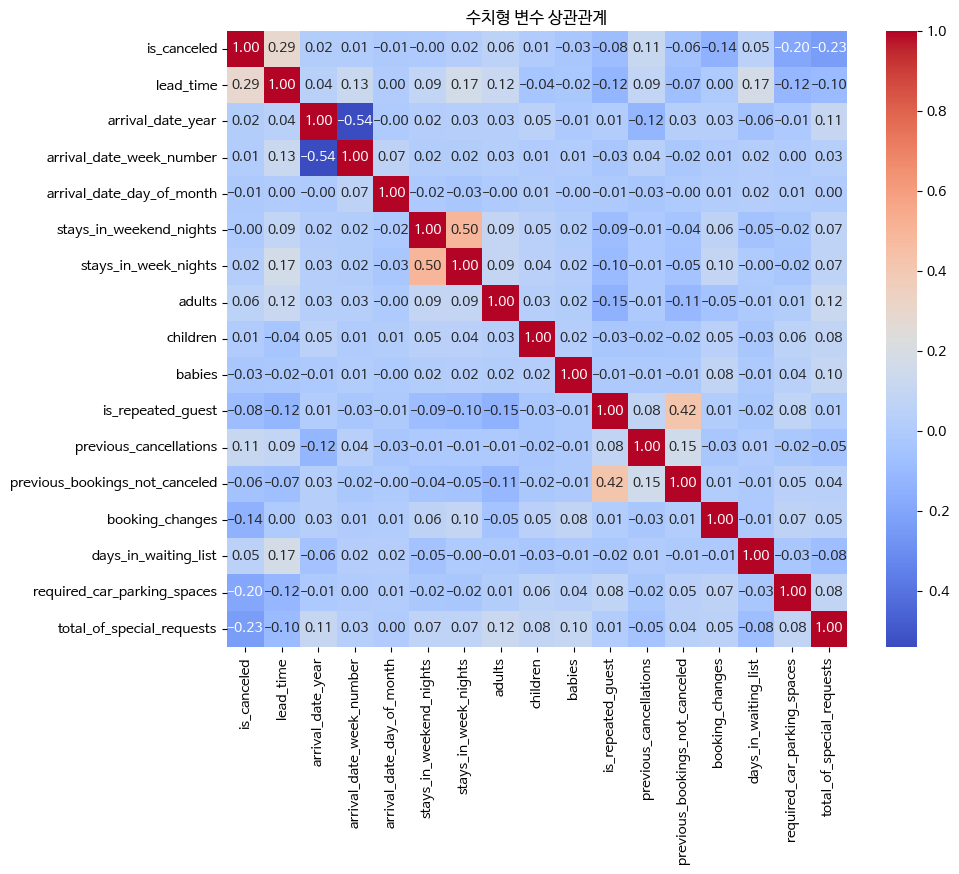

In [ ]:
# 상관관계 확인

plt.figure(figsize=(10,8))

sns.heatmap(hotel_booking[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f") # corr()은 상관계수를 계산하는 메서드, annot은 수치값 표시 파라미터

plt.title("수치형 변수 상관관계")

plt.show()

### 상관관계 히트맵 인사이트
- 재방문 고객이 취소율이 높지 않음을 알 수 있다.  
- 즉, 재방문률이 높은 호텔은 서비스 만족도가 높음을 의미한다.

# 4. 예약 취소율 비교

## 4.1. 전체 취소율 (No-Show 포함)

예약 취소율:
 is_canceled
0    62.958372
1    37.041628
Name: proportion, dtype: float64


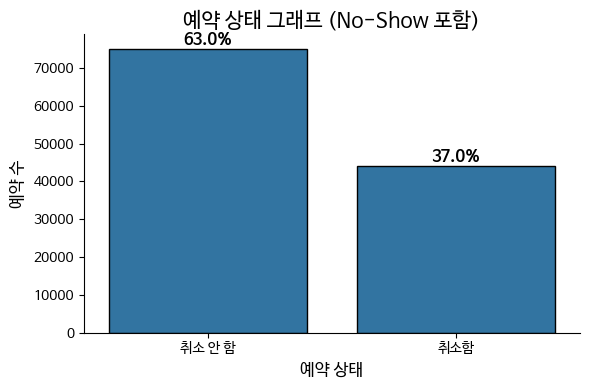

In [ ]:
# 전체 취소율(no_show 포함)
cancelled_percentage = hotel_booking['is_canceled'].value_counts(normalize=True) * 100  # normalize=True 파라미터는 각 값의 빈도
per_total = len(hotel_booking['is_canceled'])
print("예약 취소율:\n", cancelled_percentage)

# 범주형 데이터 개수를 세서 막대 그래프로 표시하는 countplot 사용
plt.figure(figsize=(6, 4))
graph1 = sns.countplot(
    x=hotel_booking['is_canceled'].map({0: '취소 안 함', 1: '취소함'}),   # map()은 보통 함수 일괄 적용하는 데 사용되기도 하지만 여기서는 딕셔너리 일괄 매핑에 사용됨
    order=['취소 안 함', '취소함'],
    edgecolor='black'
)

# 레이블 붙이기
for p in graph1.patches:  # patches로 도형 객체 리스트 불러오기
    height = p.get_height()
    graph1.annotate(f'{(height / per_total * 100):.1f}%',
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=12, fontweight='bold', color='black')

plt.title('예약 상태 그래프 (No-Show 포함)', fontsize=15)
plt.xlabel('예약 상태', fontsize=12)
plt.ylabel('예약 수', fontsize=12)
sns.despine() # 그래프 상단과 우측 테두리 제거
plt.tight_layout()  # 그래프 내부 요소들이 겹치지 않도록 자동 여백 조정
plt.show()

## 4.2. 전체 취소율 (No-Show 제외)

예약 취소율:
 reservation_status
Check-Out    63.601364
Canceled     36.398636
Name: proportion, dtype: float64


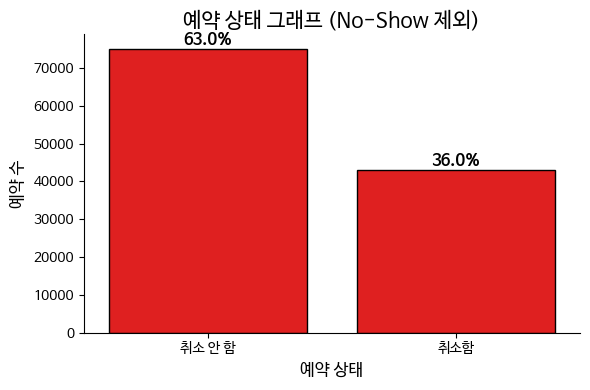

In [ ]:
# 전체 취소율(no_show 제외)
n_cancelled_percentage = hotel_booking[~no_show_condition]['reservation_status'].value_counts(normalize=True) * 100
n_per_total = len(hotel_booking['reservation_status'])
print("예약 취소율:\n", n_cancelled_percentage)

# 범주형 데이터 개수를 세서 막대 그래프로 표시하는 countplot 사용
plt.figure(figsize=(6, 4))
graph2 = sns.countplot(
    x=hotel_booking[~no_show_condition]['reservation_status'].map({'Check-Out': '취소 안 함', 'Canceled': '취소함'}),
    order=['취소 안 함', '취소함'],
    color='red',
    edgecolor='black'
)

# 레이블 붙이기
for p in graph2.patches:
    height = p.get_height()
    graph2.annotate(f'{(height / n_per_total * 100):.1f}%',
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=12, fontweight='bold', color='black')

plt.title('예약 상태 그래프 (No-Show 제외)', fontsize=15)
plt.xlabel('예약 상태', fontsize=12)
plt.ylabel('예약 수', fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()


### 전체 취소율 통계 결과

취소율과 별개인 No_Show를 제외해도 퍼센트에 큰 차이는 없다.  
따라서 No_Show 값이 의도적인 예약 취소와는 다르다는 점을 감안할 때, 이후로는 No_Show 제외를 기준으로 한다.

## 4.3. 호텔별 취소율

예약 취소율 (지표):
 hotel         is_canceled
City Hotel    0              46228
              1              32186
Resort Hotel  0              28938
              1              10831
Name: count, dtype: int64
예약 취소율 (퍼센트):
 hotel         is_canceled
City Hotel    0              58.953758
              1              41.046242
Resort Hotel  0              72.765219
              1              27.234781
Name: proportion, dtype: float64


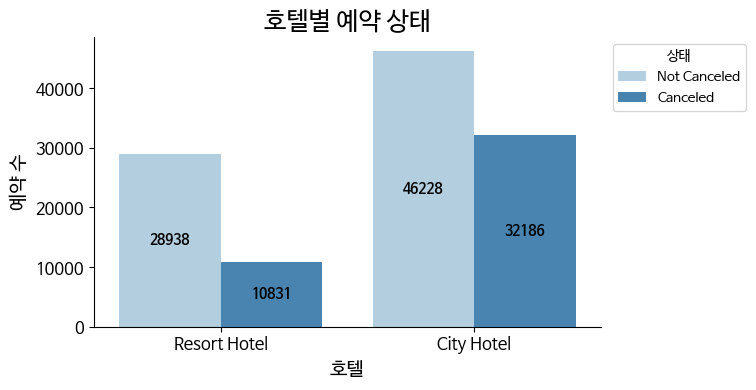

In [ ]:
# 호텔별 취소율(no_show 제외)
excluded_booking = hotel_booking[~no_show_condition]
s_cancelled_percentage = excluded_booking.groupby('hotel')['is_canceled'].value_counts(normalize=True)
s_per_total = len(excluded_booking.groupby('hotel')['is_canceled'])
print("예약 취소율 (지표):\n", excluded_booking.groupby('hotel')['is_canceled'].value_counts())
print("예약 취소율 (퍼센트):\n", s_cancelled_percentage * 100)

plt.figure(figsize=(8, 4))
graph3 = sns.countplot(
    data=excluded_booking,
    x='hotel',
    hue='is_canceled',
    palette='Blues'
)

# 숫자 라벨 표시 부분
for container in graph3.containers:
    graph3.bar_label(container, label_type='center', fmt='%d', color='black', fontsize=10, fontweight='bold')

graph3.legend_.set_bbox_to_anchor((1.3, 1))  # set_bbox_to_anchor로 범례 위치 조정
plt.title('호텔별 예약 상태', fontsize=18)
plt.xlabel('호텔', fontsize=14)
plt.ylabel('예약 수', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Not Canceled', 'Canceled'], title='상태', bbox_to_anchor=(1.3, 1))
sns.despine()
plt.tight_layout()
plt.show()

### 호텔별 통계 결과
- 예약 수는 도시 호텔이 **46,228건** 리조트 호텔이 **28,938건**으로 **도시 호텔이 압도적으로 높다**.
- 예약 취소율은 도시 호텔이 **41퍼센트** 리조트 호텔이 **27퍼센트**로 **리조트 호텔이 압도적으로 낮다**.

# 집단 규모별 예약 취소율

## 5.1. 전체 집단 규모별 예약율과 예약 취소율
- 아기, 어린이를 포함하거나 3명 이상의 어른을 포함한 그룹
- 1~2명의 어른만 포함한 그룹

In [ ]:
# 그룹 분리 함수 작성
def classify_group(row):
    if row['children'] > 0 or row['babies'] > 0 or row['adults'] >= 3:
        return '가족/다수 여행'
    else:
        return '비즈니스/소수 여행'

excluded_booking['customer_type'] = excluded_booking.apply(classify_group, axis=1)

/tmp/ipython-input-269496232.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  excluded_booking['customer_type'] = excluded_booking.apply(classify_group, axis=1)


집단별 예약 상황:
 is_canceled        0      1
customer_type              
가족/다수 여행        9853   5079
비즈니스/소수 여행     65313  37938


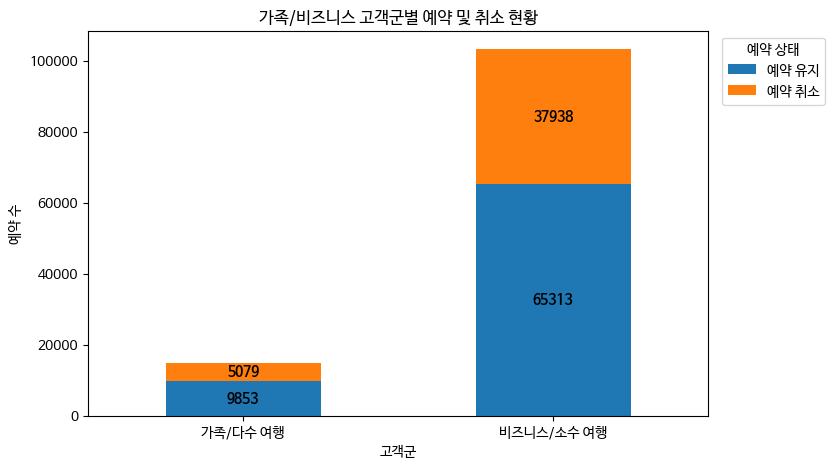

In [ ]:
# unstack으로 행 인덱스를 열로 바꾸어 새로운 데이터프레임 생성. 참고로 stack은 역으로 열을 인덱스로 옮긴다.
group_stats = excluded_booking.groupby(['customer_type', 'is_canceled']).size().unstack(level='is_canceled')

print('집단별 예약 상황:\n', group_stats)

group_stats_per = group_stats.plot(
    kind='bar',
    stacked=True, # 중첩 막대기로 표현
    figsize=(8,5),
    title='가족/비즈니스 고객군별 예약 및 취소 현황'
)

for container in group_stats_per.containers:
    group_stats_per.bar_label(container, label_type='center', fmt='%d', color='black', fontsize=10, fontweight='bold')

group_stats_per.legend_.set_bbox_to_anchor((1.3, 1))
plt.xlabel('고객군')
plt.ylabel('예약 수')
plt.legend(['예약 유지', '예약 취소'], title='예약 상태', bbox_to_anchor=(1.2, 1))
plt.xticks(rotation=0)
plt.show()

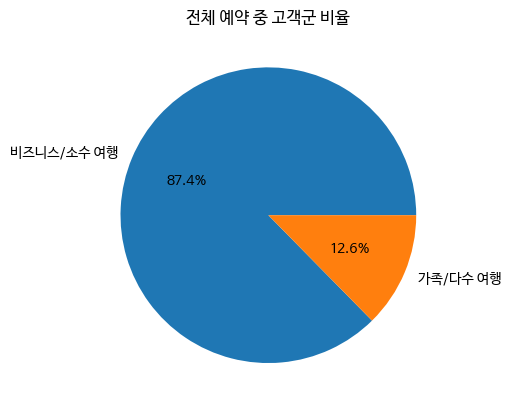

In [ ]:
# 전체에서 각 집단이 차지하는 비율
excluded_booking['customer_type'].value_counts().plot.pie(
    autopct='%1.1f%%',  # 정규표현식으로 파이에 표시할 퍼센트 텍스트 설정
    title='전체 예약 중 고객군 비율',
    ylabel=''
)
plt.show()

## 5.2. 호텔별 집단 규모별 예약율과 예약 취소율

In [ ]:
# 호텔, 고객유형, 취소 여부별 예약수 집계
group_stats2 = excluded_booking.groupby(['hotel', 'customer_type', 'is_canceled']).size().unstack(level='is_canceled').reset_index()
group_stats2

is_canceled,hotel,customer_type,0,1
0,City Hotel,가족/다수 여행,6456,3506
1,City Hotel,비즈니스/소수 여행,39772,28680
2,Resort Hotel,가족/다수 여행,3397,1573
3,Resort Hotel,비즈니스/소수 여행,25541,9258


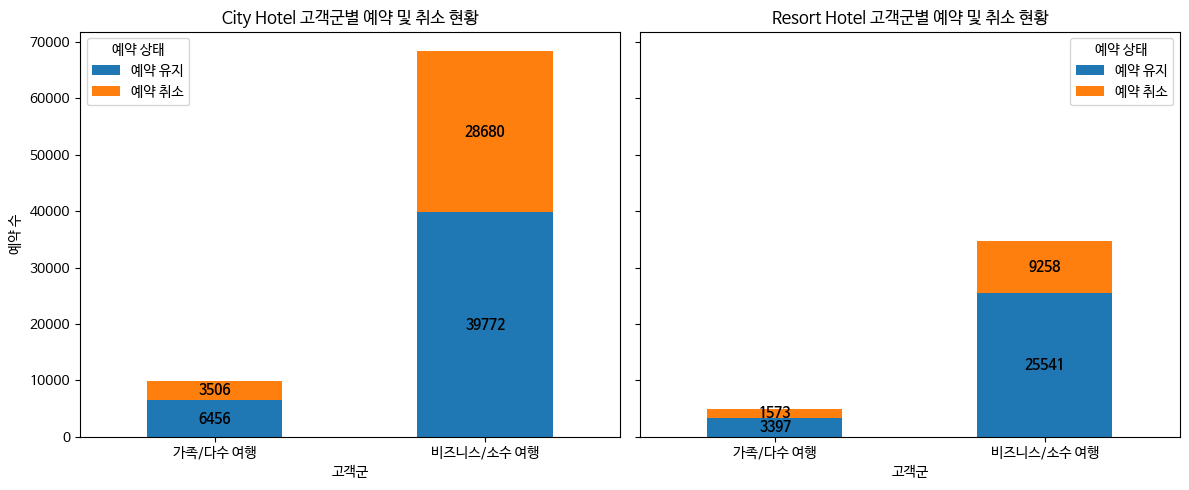

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # 여러 개의 서브플롯 생성(1행 2열)하고 fig와 axes에 각각 전제 그림과 각 서브플롯 배열 할당

hotels = group_stats2['hotel'].unique()

for i, hotel_name in enumerate(hotels):
    data = group_stats2[group_stats2['hotel'] == hotel_name].set_index('customer_type')

    hotels_group = data.plot(
        kind='bar',
        stacked=True,
        ax=axes[i],
        title=f'{hotel_name} 고객군별 예약 및 취소 현황',
    )
    axes[i].set_xlabel('고객군')
    axes[i].set_ylabel('예약 수')
    axes[i].legend(['예약 유지', '예약 취소'], title='예약 상태')
    axes[i].tick_params(axis='x', rotation=0)

    for container in hotels_group.containers:
        hotels_group.bar_label(container, label_type='center', fmt='%d', color='black', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### 집단 규모별 통계 결과
- 전체 규모에서 비즈니스/소수 고객이 **87.4퍼센트**, 가족/다수 고객이 **12.6퍼센트**로 비즈니스/소수 고객이 예약율에서 압도적으로 많다.
- 예상과 달리 취소율 자체는 비즈니스/소수 층과 가족/다수 층 사이에 큰 차이는 없다.
- 비즈니스/소수 고객층의 경우, Resort Hotel보다 City Hotel에서 더 높은 취소율을 보인다.

# 6. 재이용 고객의 예약 취소율 및 비율

## 6.1. 전체에서 재이용 고객 비율

In [ ]:
# 재이용 고객 정보 확인
excluded_booking[excluded_booking['is_repeated_guest'] == 1]['is_repeated_guest']

,is_repeated_guest
13937,1
14681,1
14777,1
14817,1
14823,1
...,...
117701,1
117841,1
117961,1
118029,1


In [ ]:
# 재이용 여부별 예약 상태 확인
excluded_booking.groupby('is_repeated_guest')['is_canceled'].value_counts()

is_repeated_guest  is_canceled
0                  0              71908
                   1              42510
1                  0               3258
                   1                507
Name: count, dtype: int64

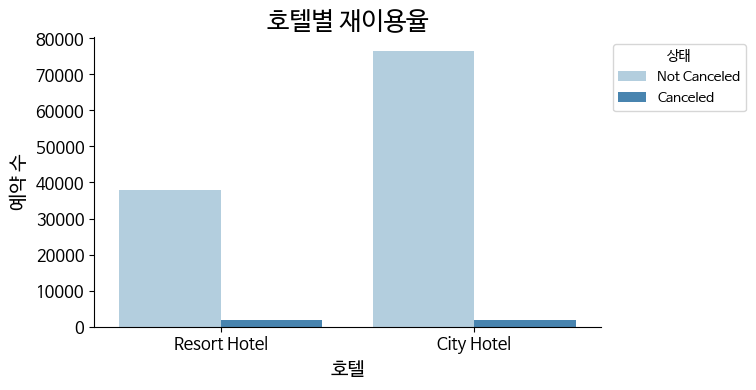

In [ ]:
#호텔별 재이용률
s_repeat_percentage = excluded_booking.groupby('hotel')['is_repeated_guest'].value_counts(normalize=True)
s_per_total = len(excluded_booking.groupby('hotel')['is_repeated_guest'])

plt.figure(figsize=(8, 4))
repeat_graph = sns.countplot(
    data=excluded_booking,
    x='hotel',
    hue='is_repeated_guest',
    palette='Blues'
)

# 숫자 라벨 표시 부분
for container in repeat_graph.containers:
    graph3.bar_label(container, label_type='center', fmt='%d', color='black', fontsize=10, fontweight='bold')

repeat_graph.legend_.set_bbox_to_anchor((1.3, 1))  # set_bbox_to_anchor로 범례 위치 조정
plt.title('호텔별 재이용율', fontsize=18)
plt.xlabel('호텔', fontsize=14)
plt.ylabel('예약 수', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Not Canceled', 'Canceled'], title='상태', bbox_to_anchor=(1.3, 1))
sns.despine()
plt.tight_layout()
plt.show()

### 재이용 고객 예약 취소율 통계 결과
- 처음 사용 고객과 비교해서 재이용 고객의 취소율이 압도적으로 낮다는 것을 알 수 있다.
- 재이용 고객은 서비스 만족도가 높다는 것을 알 수 있다.

## 6.2. 호텔별 재이용률

In [ ]:
#호텔별 재이용률 비교 프레임 생성
hrepeated_sum_table = excluded_booking.groupby('hotel')['is_repeated_guest'].value_counts().reset_index()
hrepeated_sum_table

,hotel,is_repeated_guest,count
0,City Hotel,0,76418
1,City Hotel,1,1996
2,Resort Hotel,0,38000
3,Resort Hotel,1,1769


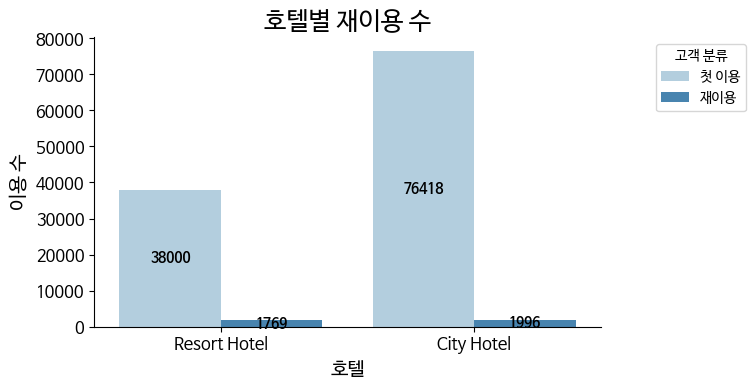

In [ ]:
# 호텔별 재이용 수
plt.figure(figsize=(8, 4))
repeat_graph = sns.countplot(
    data=excluded_booking,
    x='hotel',
    hue='is_repeated_guest',
    palette='Blues'
)

# 숫자 라벨 표시 부분
for container in repeat_graph.containers:
    repeat_graph.bar_label(container, label_type='center', fmt='%d', color='black', fontsize=10, fontweight='bold')

repeat_graph.legend_.set_bbox_to_anchor((1.3, 1))
plt.title('호텔별 재이용 수', fontsize=18)
plt.xlabel('호텔', fontsize=14)
plt.ylabel('이용 수', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['첫 이용', '재이용'], title='고객 분류', bbox_to_anchor=(1.3, 1))
sns.despine()
plt.tight_layout()
plt.show()

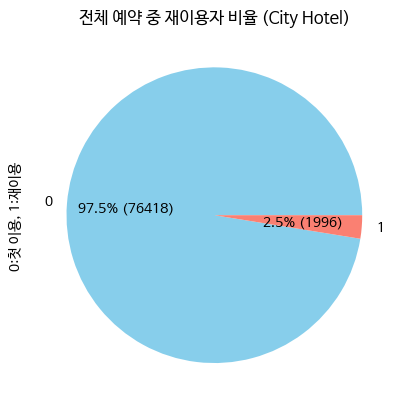

In [ ]:
# City Hotel만 선택
city_hotel_r = excluded_booking[excluded_booking['hotel'] == 'City Hotel']


# is_repeated_guest 비율 파이 차트
counts1 = city_hotel_r['is_repeated_guest'].value_counts()  # 0, 1 개수 계산

counts1.plot.pie(
    title='전체 예약 중 재이용자 비율 (City Hotel)',
    ylabel='0:첫 이용, 1:재이용',
    autopct=lambda x: f'{x:.1f}% ({round(x*counts1.sum()/100)})',  # 퍼센트 + 실제 개수
    colors=['skyblue', 'salmon']
)

plt.show()

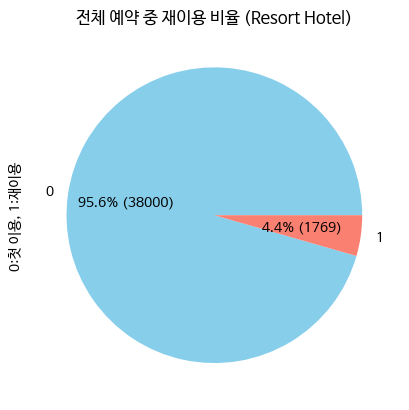

In [ ]:
# Resort Hotel만 선택
resort_hotel_r = excluded_booking[excluded_booking['hotel'] == 'Resort Hotel']


# is_repeated_guest 비율 파이 차트
counts2 = resort_hotel_r['is_repeated_guest'].value_counts()

counts2.plot.pie(
    title='전체 예약 중 재이용 비율 (Resort Hotel)',
    ylabel='0:첫 이용, 1:재이용',
    autopct=lambda x: f'{x:.1f}% ({round(x*counts2.sum()/100)})',
    colors=['skyblue', 'salmon']
)

plt.show()

### 호텔별 재이용률 결과
- 둘 다 재이용률이 낮지만, Resort Hotel이 City Hotel보다 약 2배 높다.
- 따라서 Resort Hotel의 서비스 만족도가 상대적으로 더 좋다.

# 종합

## 7.1. 각 항목 분석 결과

### 1. 리조트 호텔과 도시 호텔 중 어느쪽이 예약율 및 취소율이 높은가?
- 예약 수는 시티 호텔이 높지만, 예약 취소율은 리조트 호텔이 압도적으로 낮다.  

### 2. 가족(혹은 다수)에 친화적인가 비즈니스 목적(혹은 소수)에 친화적인가?
- 전체 규모에서 비즈니스/소수 고객이 가족/다수 고객보다 예약율에서 압도적으로 높다.
- 예상과 달리 취소율 자체는 비즈니스/소수 층과 가족/다수 층 사이에 큰 차이는 없다.
- 비즈니스/소수 고객층의 경우, 리조트 호텔보다 시티 호텔에서 더 높은 취소율을 보인다.

### 3. 고객이 서비스에 만족하는가?
- 처음 사용 고객과 비교해서 재이용 고객의 취소율이 압도적으로 낮다는 점에서 재이용 고객은 서비스 만족도가 높다는 것을 알 수 있다.
- 두 호텔 모두 재이용률이 낮지만, 리조트 호텔이 시티 호텔보다 약 2배 높다.

## 7.2. 제안

- 시티 호텔은 예약 수에서 훨씬 높지만 비즈니스/소수 고객이 다수를 차지하고 있으며, 취소율도 높다. 이는 기업이 많은 지역적 특징에 따른 결과로 보인다.
- 반면 리조트 호텔은 지역 특징상 휴양 목적이 많은 것으로 생각된다.
- 비록 리조트 호텔의 재이용률이 시티 호텔보다 약 2배 더 높지만, 둘 다 높은 재이용률을 보이지 못한다.
- 리조트 호텔의 경우, 가족/다수 고객층을 좀 더 높일 수 있도록 가족 친화적인 서비스를 강화할 필요가 있어 보인다. (예시: 가족 할인, 베이비 시트 등 유아 특화 서비스)
- 시티 호텔의 경우, 비즈니스 사정상 취소율이 높은 것은 호텔 자체의 문제라고 하기 어렵지만, 낮은 재이용률은 서비스상의 부족을 의미할 수 있으며, 비즈니스 고객에 조금 더 친화적인 서비스의 강화가 필요해 보인다. (예시: 조기 체크인 지원)